# Covid 19 Probabilities

The data analyst firm you work for has been contracted by a local Health Authority to conduct a risk assessment of Covid-19.

Your research supervisor has asked you to use the latest CDC case data to preform a Bayesian analysis to calculate the probability of death from Covid-19 among certain demographics.

# Part 1 - Download data
In order to import the data from the CDC, you'll first need to install a python library to give you access to the Socrata API used by the CDC:

    !pip install sodapy

After that, you'll need to import the latest Covid-19 case data. For an example of how to do so, visit the [Socrata CDC API Site for the Covid-19 case data](https://dev.socrata.com/foundry/data.cdc.gov/vbim-akqf/), scroll down to the section labeled `Code Snippets`, and click on the `Python Pandas` tab.

*Some things to note:*

* Since this is public data, you do not need to use an authentication token. 

* Instead of fetching 2,000 records as in the example, set your limit to 3,000,000 records. This will retrieve approximately 3/4 of the data.

* You can name your variables whatever you want. For example, when converting the data into a dataframe, you could do:


    cases = pd.DataFrame.from_records(results)

* With that many records, it will take a bit of time to download. Be careful to put the download command in a separate code cell from the rest of your analysis work, so that Colab doesn't rerun the download command everytime you make a change to your analysis.

In [13]:
# Install sodapy and import libraries
!pip install sodapy

In [14]:
from sodapy import Socrata
import pandas as pd
import seaborn as sns

### Initial data analysis
Once you have imported the data, perform a brief analysis to become familiar with the data.


In [15]:
# Initial data analysis
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cdc.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cdc.gov,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("vbim-akqf", limit=3000000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

# Part 2 - Age Demographics

The research director would like you to start by doing a simple age-based risk assessment. To do so, complete the following tasks:

* First, check to see [how many samples there are in each age bracket](https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/06_calculate_statistics.html#count-number-of-records-by-category).
* Next, [filter out any records](https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/03_subset_data.html#how-do-i-filter-specific-rows-from-a-dataframe) that have the values `NA` or `Unknown` for the `age_group` column, and check the counts again.  (You may find this task easier if you use a "negation" of the `isin()` function, as [discussed here](https://stackoverflow.com/questions/19960077/how-to-filter-pandas-dataframe-using-in-and-not-in-like-in-sql).


In [5]:
# See what the values are
results_df.head()

,cdc_report_dt,pos_spec_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,onset_dt
0,2020-03-03T00:00:00.000,2020-03-03T00:00:00.000,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,Missing,Missing,Missing,Missing,NaN
1,2020-03-03T00:00:00.000,2020-03-03T00:00:00.000,Laboratory-confirmed case,Female,0 - 9 Years,Unknown,Missing,Missing,Missing,Missing,NaN
2,2020-04-07T00:00:00.000,2020-03-03T00:00:00.000,Laboratory-confirmed case,Unknown,0 - 9 Years,Unknown,No,Missing,Missing,Missing,2020-03-03T00:00:00.000
3,2020-08-04T00:00:00.000,2020-08-04T00:00:00.000,Probable Case,Male,0 - 9 Years,Unknown,Missing,Missing,Missing,Missing,NaN
4,2020-07-28T00:00:00.000,2020-08-04T00:00:00.000,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,No,No,No,Missing,2020-07-28T00:00:00.000


In [6]:
results_df["age_group"].value_counts()

20 - 29 Years    614735
40 - 49 Years    580660
50 - 59 Years    564999
60 - 69 Years    380136
10 - 19 Years    234374
30 - 39 Years    219768
80+ Years        206172
0 - 9 Years      108318
70 - 79 Years     86698
Unknown            4046
NA                   94
Name: age_group, dtype: int64

In [7]:
# Filter out rows with missing age group values
real_results = results_df[~results_df["age_group"].isin(["NA", "Unknown"])]
# Check the updated counts
real_results["age_group"].value_counts()

20 - 29 Years    614735
40 - 49 Years    580660
50 - 59 Years    564999
60 - 69 Years    380136
10 - 19 Years    234374
30 - 39 Years    219768
80+ Years        206172
0 - 9 Years      108318
70 - 79 Years     86698
Name: age_group, dtype: int64

### Additional Cleanup
The research director tells you that you're going to be primarily working answer questions regarding age (`age_group`), pre-existing medical conditions (`medcond_yn`), and whether or not the patient died (`death_yn`). 

You've alread filtered out rows that were missing data for the `age_group` column, now check for missing values in the other two columns you'll be working with, then filter the data as needed, and see how many samples that leaves in the data set.

* Make sure you start with the filtered dataset, not the original.
* Make sure you pay attention to which values represent missing or unknown data for each column and filter accordingly.

In [8]:
# Perform additional filtering
real_results = real_results[~real_results["medcond_yn"].isin(["NA", "Unknown", "Missing"])]
real_results = real_results[~real_results["death_yn"].isin(["NA", "Unknown", "Missing"])]

In [9]:
real_results["medcond_yn"].value_counts()

Yes    281739
No     200657
Name: medcond_yn, dtype: int64

In [10]:
real_results["death_yn"].value_counts()

No     425627
Yes     56769
Name: death_yn, dtype: int64

In [11]:
real_results.head()

,cdc_report_dt,pos_spec_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,onset_dt
25,2020-08-10T00:00:00.000,2020-08-04T00:00:00.000,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,No,No,No,No,2020-08-03T00:00:00.000
27,2020-08-10T00:00:00.000,2020-08-04T00:00:00.000,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,No,No,No,No,2020-08-03T00:00:00.000
28,2020-08-09T00:00:00.000,2020-08-04T00:00:00.000,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,Missing,Missing,No,No,2020-08-04T00:00:00.000
45,2020-08-04T00:00:00.000,2020-08-04T00:00:00.000,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,No,Unknown,No,No,NaN
50,2020-08-10T00:00:00.000,2020-08-04T00:00:00.000,Laboratory-confirmed case,Male,0 - 9 Years,Unknown,No,No,No,No,2020-08-04T00:00:00.000


# Part 3 - Probabilities

Your research director would now like you to calculate the probability that someone in a given age demographic will die, given that they have Covid-19.

Use the [`crosstab()` function](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html#cross-tabulations) to answer this qustion. You may find [this guide](https://pbpython.com/pandas-crosstab.html) useful.

* Be careful how your normalize...we want the probabilties within each age group.




In [19]:
summary = pd.crosstab(real_results['death_yn'], real_results['age_group'], margins=True, normalize='columns')
summary

age_group,0 - 9 Years,10 - 19 Years,20 - 29 Years,30 - 39 Years,40 - 49 Years,50 - 59 Years,60 - 69 Years,70 - 79 Years,80+ Years,All
death_yn,,,,,,,,,,
No,0.998715,0.99938,0.997281,0.991997,0.976428,0.937983,0.817037,0.662983,0.414779,0.882319
Yes,0.001285,0.00062,0.002719,0.008003,0.023572,0.062017,0.182963,0.337017,0.585221,0.117681


In [20]:
# Use the crosstab function to calcuate the probabilties, normalized across columns
pd.crosstab(real_results["age_group"], real_results["death_yn"], margins=True, normalize = "index")

death_yn,No,Yes
age_group,,
0 - 9 Years,0.998715,0.001285
10 - 19 Years,0.999380,0.000620
20 - 29 Years,0.997281,0.002719
30 - 39 Years,0.991997,0.008003
40 - 49 Years,0.976428,0.023572
50 - 59 Years,0.937983,0.062017
60 - 69 Years,0.817037,0.182963
70 - 79 Years,0.662983,0.337017
80+ Years,0.414779,0.585221


In [21]:
pd.crosstab(real_results["age_group"], real_results["death_yn"], margins=True, normalize = "columns")

death_yn,No,Yes,All
age_group,,,
0 - 9 Years,0.034683,0.000335,0.030641
10 - 19 Years,0.068194,0.000317,0.060206
20 - 29 Years,0.172336,0.003523,0.152470
30 - 39 Years,0.140376,0.008491,0.124856
40 - 49 Years,0.186083,0.033680,0.168148
50 - 59 Years,0.190857,0.094611,0.179531
60 - 69 Years,0.116752,0.196022,0.126081
70 - 79 Years,0.043834,0.167063,0.058336
80+ Years,0.046884,0.495957,0.099731


### Visualize the data

Use Pandas' [built in plotting functions](https://pandas.pydata.org/docs/user_guide/visualization.html#bar-plots) to create a stacked bar chart of the crosstab summary.

* In order to get a visualization that makes sense, you may first need to [Transpose](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html) the summary table.

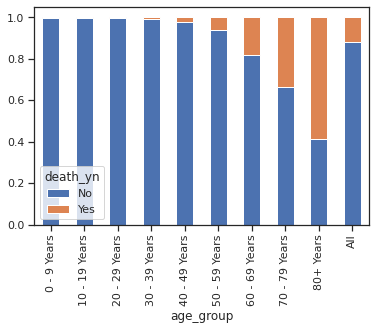

In [22]:
# Transpose and plot the summary table as a stacked bar chart
import seaborn as sns
sns.set()
sns.set_style('ticks')
summary.T.plot(kind='bar', stacked=True)

# Part 4 - Bayesian Prediction

Your research director would like you to use a Bayesian Classifier to predict the probability that someone with Covid-19 will die or not, given their age bracket and medical status.

You'll be using [SciKit Learn's Bayesian Classifer](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) for this task.

Our use of the Bayseian Classifier in SciKit learn will have four steps. As you'll see later in the semester, some machine learning taks involve additional steps:

1. Create an instance of the classifer
2. Provide the classifier with the data it will use to build its prediction model. This is sometimes called "fitting" or "training" the model.
3. Ask the model to make a prediction by providing it with new data.
4. Interpret the prediction.

Parts of these steps will be provided for you in this exercise:

In [23]:
# Step 1
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
filtered = real_results

### Train the Classifer
Now we need to teach the classifier how to make a prediction based on historic data. In terms of Bayes' Theorem, we are providing the classifier with the data it needs to calculate hte conditional and joint probabilties for a particuar event.

One caveat to using most machine learning libraries is that they don't do well with textural feature data. For example, our `age_group` column contains strings indicating the patient's age bracket. The `medcond_yn` column contains strings ("Yes" or "No") indicating whether the patient had a pre-existing medical condition.

Before we can give this data to the classifier, we'll need to "encode" it unto numeric form. There are lots of ways to do this, including some built-in ways in SciKit Learn, but for now we'll use the Pandas `map()` function, which we've used before. (If you've forgotten, see the teacher's solution to [Data Exploration 02](https://byui-cse.github.io/cse450-course/module-01/exploration-02.html))

Below, the `age_group` column has been encoded into a set of numeric values. You may want to verify using the `value_counts()` function that the counts of the encoded values match up with the originals.

In [24]:
# This code assumes your filtered dataset is stored in a variable called "filtered". 
# If it isn't, you'll need to update the code accordingly.
filtered['age_group_encoded'] = filtered['age_group'].map({
    '0 - 9 Years' : 0,
    '10 - 19 Years' : 1,
    '20 - 29 Years' : 2,
    '30 - 39 Years' : 3,
    '40 - 49 Years' : 4,
    '50 - 59 Years' : 5,
    '60 - 69 Years' : 6,
    '70 - 79 Years' : 7,
    '80+ Years': 8})

# Compare the below result to filtered['age_group'].value_counts()
filtered['age_group_encoded'].value_counts()

5    86605
4    81114
2    73551
6    60821
3    60230
8    48110
1    29043
7    28141
0    14781
Name: age_group_encoded, dtype: int64

Create two new columns called `death_yn_encoded` and `medcond_yn_encoded` by encoding the values of the `death_yn` and `medcond_yn` columns. 

For each column, encode "Yes" as `1` and "No" as `0`.

In [25]:
# Encode the columns
filtered['death_yn_encoded'] = filtered['death_yn'].map({
    'Yes': 1,
    'No': 0
})

filtered['medcond_yn_encoded'] = filtered['medcond_yn'].map({
    'Yes': 1,
    'No': 0
})

Now that you've encoded the textual features, the following code passes the data to the classifier to "train" or "fit" the model, allowing it to make predictions.

* The first parameter to the `fit()` function is called "X" and is the set of features we want to use to make our predictions. In our case, that is age group, and pre-existing medical condition status.

* The second parameter is called "Y" and is the target feature we're trying to predict. In our case, that is whether or not the patient died.

Nearly all SciKit Learn algorithms follow this pattern.

In [26]:
# Fit the data to the model
# Again, this code assumes your filtered data is stored in a variable called
# filtered. If not, update this code accordingly
classifier.fit( filtered[ ['age_group_encoded', 'medcond_yn_encoded'] ], filtered['death_yn_encoded'])

GaussianNB(priors=None, var_smoothing=1e-09)

### Make Predictions
Now that the model is trained, it's time to use it to make predictions. To do so, we can either use:

* The [`predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.predict) function, which in this case would tell us which event is most likely to occur.
* The [`predict_proba()`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.predict_proba) function, which tells us the probability that each event would occur.

Since our research director wants to know the probabilities, we'll use the second option.

For each prediction we want to make, we would pass the classifier one sample (row) of data contanining *encoded* values for the features it knows about.

The following code shows how we could build a Pandas DataFrame to pass to the `predict_proba()` function:



In [27]:
# Let's set the display to show floating decimal precision
# to 5 places so we avoid scientific notation
pd.options.display.float_format = '{:.5f}'.format

# Create a data frame with one sample
# Note that we build this by specifying the column name, then an 
# array of values that would go down that column.
#
# age_group_encoded | medcond_yn_encoded
# --------------------------------------
#          2        |          0        

to_predict = pd.DataFrame({
    "age_group_encoded": [2], # A 20 - 29 year old
    "medcond_yn_encoded": [0] # With no pre-existing medical conditions
})

# Wrap the results in a new Pandas data frame and display it
prediction = pd.DataFrame(classifier.predict_proba( to_predict ))

# Each row in the results is the prediction corresponding to the same row in
# our to_predict data frame. 
#
# The first column is the probability of 0 (No) for death_yn. 
# The second is the probability of 1 (Yes) for death_yn.
prediction

,0,1
0,1.00000,0.00000


In [28]:

# Create a data frame with multiple samples. 
# Note that we build these by specifying the column name, then an 
# array of values that would go down that column.
#
# age_group_encoded | medcond_yn_encoded
# --------------------------------------
#          2        |          0        
#          2        |          1        
#          5        |          1        
to_predict = pd.DataFrame({
    "age_group_encoded": [2, 2, 5], # Age groups: 20 - 29, 20 - 29, 50 - 59
    "medcond_yn_encoded": [0, 1, 1] # Pre-existing medical conditions: No, Yes, Yes
})

# Pass the data frame to the model to get a prediction,
# then wrap the results in a new Pandas data frame and display it.
prediction = pd.DataFrame(classifier.predict_proba( to_predict ))

# Each row in the results is the prediction corresponding to the same row in
# our to_predict data frame. 
#
# The first column is the probability of 0 (No) for death_yn. 
# The second is the probability of 1 (Yes) for death_yn.
prediction

,0,1
0,1.00000,0.00000
1,0.99923,0.00077
2,0.75364,0.24636


For each of the following situations, use the classifier's `predict_proba()` function to predict the probability that a patient will die from Covid-19.

* A 25 year-old with no pre-existing medical conditions.
* A 25 year-old with pre-existing medical conditions.
* A 55 year-old with no pre-existing medical conditions.
* A 55 year-old with pre-existing medical conditions.
* An 80 year-old with no pre-existing medical conditions.
* An 80 year-old with pre-existing medical conditions.

Note that you can make these predictions one at a time, or all at once by passing multiple sets of data to the classifier. The results will be returned in the same order as the sample data provided.

In [29]:
# Make the requested predictions
to_predict = pd.DataFrame({
    "age_group_encoded": [2, 2, 5, 5, 8, 8], # Age groups
    "medcond_yn_encoded": [0, 1, 0, 1, 0, 1] # Pre-existing medical conditions
})

prediction = pd.DataFrame(classifier.predict_proba(to_predict) )
prediction

,0,1
0,1.00000,0.00000
1,0.99923,0.00077
2,1.00000,0.00000
3,0.75364,0.24636
4,1.00000,0.00000
5,0.14618,0.85382


# Part 5: Conclusions

Based on your results, what conclusions would your provide to your research manager to pass along to the health authority? What caveats about the analysis would you include? Is this model accurate? How could you test that?

Given what you know about Bayesian models from the reading, why might the model predict that an 80 year old with no pre-existing conditions would have a 100% probability of survival?

We can conclude that as you get older your probability of death increases.

## 🌟 Above and Beyond 🌟

The research director would like you to answer the following questions:

* How does gender affect the probability of death from Covid-19?
* If we look at likelihood of being admitted to the ICU instead of the likelihood of death, what are the probabilties across different age groups and medical statuses?
* How do the probabilities you calculated compare to the probabilties you would get if you looked only at the last three months worth of cases? You may need to review the Pandas tutorial on [How to Handle Timeseries Data](https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/09_timeseries.html).
* SciKit Learn has [several different Bayesian classifiers](https://scikit-learn.org/stable/modules/naive_bayes.html). Would a different classifier produce better results? How could you test that hypothesis?

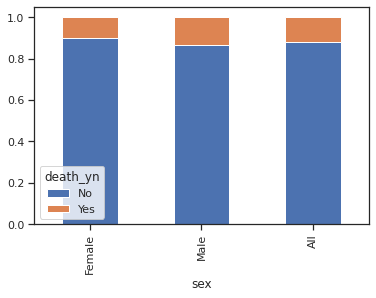

In [31]:
real_results = real_results[~real_results["sex"].isin(["NA", "Unknown", "Missing", "Other"])]

dat = pd.crosstab(real_results['death_yn'], real_results['sex'], margins=True, normalize='columns')
dat

sns.set()
sns.set_style('ticks')
dat.T.plot(kind='bar', stacked=True)